In [2]:
import numpy as np
import matplotlib.pyplot as plt
from kontrol.utils import quad_sum
data=np.loadtxt('BS_IP_noise.txt')
f, seisl, seist, lvdtl, lvdtt, geol, geot = data[:,0],data[:,1],data[:,2],data[:,3],data[:,4],data[:,5],data[:,6]
mask = f>1e-2
f=f[mask]
seisl=seisl[mask]
seist=seist[mask]
lvdtl=lvdtl[mask]
lvdtt=lvdtt[mask]
geol=geol[mask]
geot=geot[mask]
# print(data)

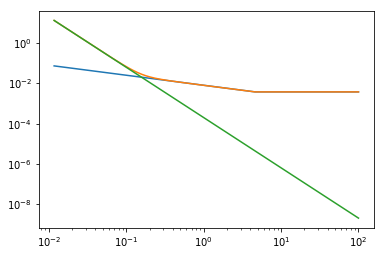

In [3]:
# plt.loglog(f,lvdtl)
# plt.loglog(f,geol)
# plt.loglog(f,2e-4/f**2.5)
# seismeter_model = lambda N_0, f: N_0/f**2.5
def noise_model(N_0, f_c, a, b, f):
    noise = np.zeros_like(f)
    for i in range(len(f)):
        if f[i]<=f_c:
            noise[i]=N_0*f[i]**a
        else:
            noise[i]= N_0*f_c**(a-b)*f[i]**b
    return(noise)
def seismometer_model(N_0, f):
    return(noise_model(N_0, 0, -2.5, -2.5, f))
def lvdt_model(N_0, f_c, f):
    return(noise_model(N_0, f_c, -0.5, 0, f))
def geo_model(N_0, f_c, f, *args):
    return(noise_model(N_0, f_c, -3.5, -1, f))
def noise_low_model(seis_N_0, lvdt_N_0, lvdt_f_c, f, *args):
    noise = quad_sum(seismometer_model(seis_N_0, f), lvdt_model(lvdt_N_0, lvdt_f_c, f))
    return(noise)
plt.loglog(f, lvdt_model(8e-3, 4.5, f))
# plt.loglog(f, geo_model(2e-6, 0.9, f))
plt.loglog(f, noise_low_model(2e-4, 8e-3, 4.5, f))
plt.loglog(f, seismometer_model(2e-4, f))
weight = np.ones_like(f)
for i in range(len(f)):
    if f[i]>0.04 and f[i]<0.5:
        weight[i]=0

In [4]:
def cost(args, noise_measurement, noise_model, f, weight):
    args=list(args)
    args.append(f)
    noise_predict = noise_model(*args)
    residue = 0
    for i in range(len(noise_measurement)):
        residue += ((noise_measurement[i]-noise_predict[i])/noise_measurement[i]*weight[i])**2
    return(residue)

In [6]:
from scipy.optimize import dual_annealing, differential_evolution
lvdtl_res = differential_evolution(cost, args = (lvdtl, noise_low_model, f, weight), bounds = [(0,1),(0,1),(1,10)])
lvdtt_res = differential_evolution(cost, args = (lvdtt, noise_low_model, f, weight), bounds = [(0,1),(0,1),(1,10)])



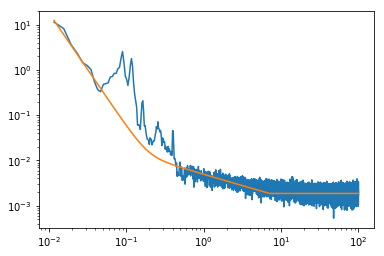

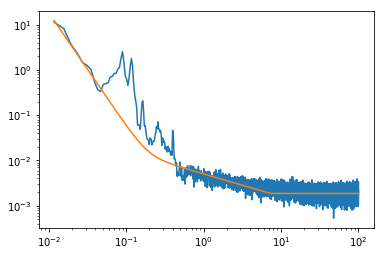

In [7]:
args=list(lvdtl_res.x)
args.append(f)
plt.loglog(f, lvdtl)
plt.loglog(f, noise_low_model(*args))
plt.figure()
args=list(lvdtt_res.x)
args.append(f)
plt.loglog(f, lvdtt)
plt.loglog(f, noise_low_model(*args))


In [8]:
weight = np.ones_like(f)
for i in range(len(f)):
    if f[i]>0.03 and f[i]<1 or f[i]>10:
        weight[i]=0
# plt.plot(f,weight)
geol_res = differential_evolution(cost, args = (geol, geo_model, f, weight), bounds = [(0,1),(0.1,10)])
geot_res = differential_evolution(cost, args = (geot, geo_model, f, weight), bounds = [(0,1),(0.1,10)])


[7.19362057e-06 7.38365472e-01]
[6.65059993e-06 5.77183830e-01]


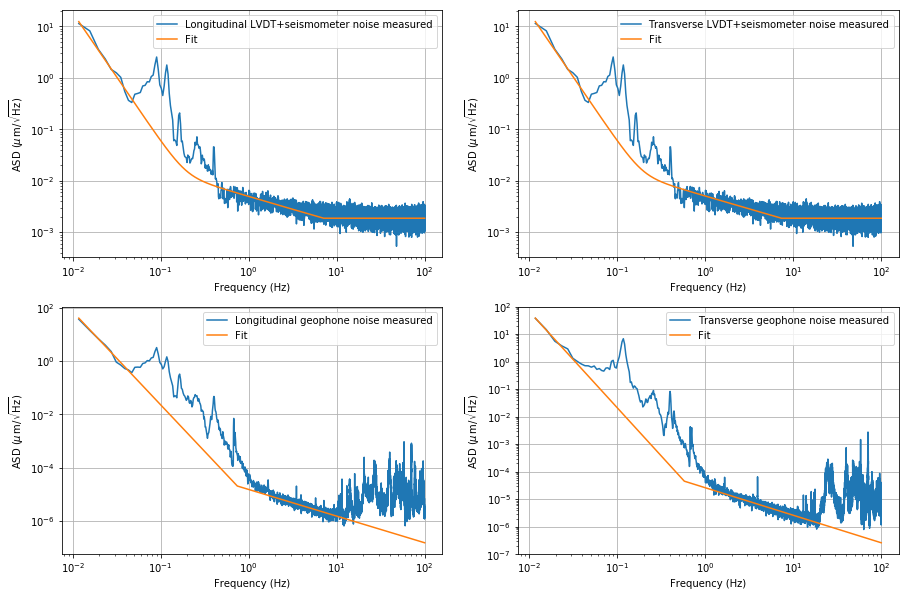

In [9]:
print(geol_res.x)
print(geot_res.x)
plt.figure(figsize=(15,10))
plt.subplot(221)
lvdtl_args=list(lvdtl_res.x)
lvdtl_args.append(f)
noisel_low=noise_low_model(*lvdtl_args)
plt.loglog(f,lvdtl, label='Longitudinal LVDT+seismometer noise measured')
plt.loglog(f,noisel_low, label='Fit')
plt.ylabel('ASD ($\mu\,\mathrm{m}/\sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()

plt.subplot(222)
lvdtt_args=list(lvdtt_res.x)
lvdtt_args.append(f)
noiset_low=noise_low_model(*lvdtt_args)
plt.loglog(f, lvdtt, label='Transverse LVDT+seismometer noise measured')
plt.loglog(f,noiset_low, label = 'Fit')
plt.ylabel('ASD ($\mu\,\mathrm{m}/\sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()

plt.subplot(223)
geol_args=list(geol_res.x)
geol_args.append(f)
geol_noise = geo_model(*geol_args)
plt.loglog(f, geol, label = 'Longitudinal geophone noise measured')
plt.loglog(f,geol_noise, label = 'Fit')
plt.ylabel('ASD ($\mu\,\mathrm{m}/\sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()

plt.subplot(224)
geot_args=list(geot_res.x)
geot_args.append(f)
geot_noise = geo_model(*geot_args)
plt.loglog(f, geot, label = 'Transverse geophone noise measured')
plt.loglog(f,geot_noise, label = 'Fit')
plt.ylabel('ASD ($\mu\,\mathrm{m}/\sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend(loc=0)
# args=list(geol_res.x)
# args.append(f)
# plt.loglog(f, geol)
# plt.loglog(f, geo_model(*args))
# plt.figure()
# args=list(geot_res.x)
# args.append(f)
# plt.loglog(f, geot)
# plt.loglog(f, geo_model(*args))

In [ ]:
lvdtl_args=list(lvdtl_res.x)
lvdtl_args.append(f)
noisel_low=noise_low_model(*lvdtl_args)
geol_args=list(geol_res.x)
geol_args.append(f)
geol_noise = geo_model(*geol_args)
plt.loglog(f,noisel_low)
plt.loglog(f,geol_noise)


In [39]:
from kontrol import optimize_complementary_filter
from kontrol import complementary_modified_sekiguchi, complementary_sekiguchi, complementary_lucia
# ?optimize_complementary_filter

res=optimize_complementary_filter(
    complementary_lucia,
    [noisel_low, geol_noise],
    f,
#     bounds = [(0.001,1),(0.001,1),(0.001,1),(0.001,1),(0.5,1000),(0.001,1),(0.5,1000)],
    x0 = [0.12*2*np.pi,0.25*2*np.pi,0.58788*2*np.pi,0.368*2*np.pi,0.673, 0.232*2*np.pi, 1.08078]
    )

Optimizing with scipy.optimize.minimize
Done. Time taken: 277.53 s The 2-norm is 13.93 unit


In [23]:
?complementary_modified_sekiguchi

In [40]:
lpf, hpf = complementary_lucia(res.x)

In [41]:
hpf


                2.808 s^8 + 212.4 s^7 + 617.4 s^6 + 4.269e+04 s^5 + 88.87 s^4 + 2838 s^3
-------------------------------------------------------------------------------------------------------
2.808 s^8 - 124.9 s^7 + 1907 s^6 - 1.081e+04 s^5 + 1.285e+04 s^4 - 6722 s^3 + 1806 s^2 - 245.3 s + 13.4

In [42]:
res.x

array([  -0.2763312 ,  -14.36213325,   75.40141661,   14.19712543,
         58.97120162,   -0.25787501, -230.03591199])

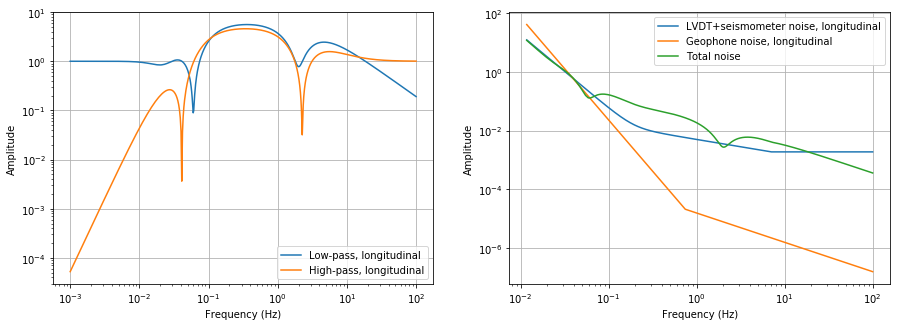

In [44]:
_f=np.linspace(0.001,100,100000)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.loglog(_f, abs(lpf.horner(2*np.pi*1j*_f)[0][0]), label = 'Low-pass, longitudinal')
plt.loglog(_f, abs(hpf.horner(2*np.pi*1j*_f)[0][0]), label = 'High-pass, longitudinal')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
# plt.vlines(0.2, 0.1,2)
# plt.figure()
# plt.semilogx(f, np.angle(lpf.horner(2*np.pi*1j*f)[0][0]))
plt.subplot(122)
plt.loglog(f, noisel_low, label = 'LVDT+seismometer noise, longitudinal')
plt.loglog(f, geol_noise, label = 'Geophone noise, longitudinal')
plt.loglog(f, quad_sum(abs(lpf.horner(2*np.pi*1j*f)[0][0])*noisel_low,
                       abs(hpf.horner(2*np.pi*1j*f)[0][0])*geol_noise),
          label = 'Total noise')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()



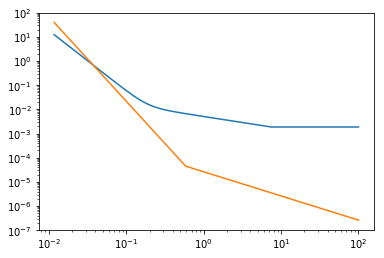

In [111]:
lvdtt_args=list(lvdtt_res.x)
lvdtt_args.append(f)
noiset_low=noise_low_model(*lvdtt_args)
geot_args=list(geot_res.x)
geot_args.append(f)
geot_noise = geo_model(*geot_args)
plt.loglog(f,noiset_low)
plt.loglog(f,geot_noise)

In [112]:
res=optimize_complementary_filter(
    complementary_sekiguchi,
    [noiset_low, geot_noise],
    f,
    bounds = [(0,10)]
    )
res.x

Optimizing with scipy.optimize.differential_evolution
Done. Time taken: 4.51 s The 2-norm is 14.49 unit


array([1.14088872])

In [114]:
res=optimize_complementary_filter(
    complementary_modified_sekiguchi,
    [noiset_low, geot_noise],
    f,
    bounds = [(0,10),(0,10),(0,10),(0,10)],
    x0 = [1.14088872,1.14088872,1.14088872,1.14088872]
    )

Optimizing with scipy.optimize.dual_annealing
Done. Time taken: 835.69 s The 2-norm is 14.49 unit


In [115]:
lpf, hpf = complementary_modified_sekiguchi(res.x)

In [117]:
lpf


  -2.206 s^6 + 5.471 s^5 + 12.22 s^4 + 18.74 s^3 + 9.618 s^2 + 2.742 s + 0.3351
----------------------------------------------------------------------------------
s^7 + 5.988 s^6 + 15.37 s^5 + 21.91 s^4 + 18.74 s^3 + 9.618 s^2 + 2.742 s + 0.3351

In [118]:
hpf


                      s^7 + 8.194 s^6 + 9.895 s^5 + 9.685 s^4
----------------------------------------------------------------------------------
s^7 + 5.988 s^6 + 15.37 s^5 + 21.91 s^4 + 18.74 s^3 + 9.618 s^2 + 2.742 s + 0.3351

In [119]:
res.x

array([1.17059192, 0.68641802, 0.65165084, 0.85539945])

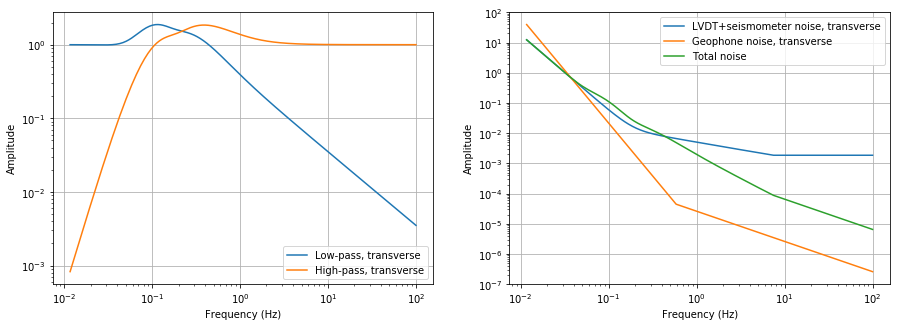

In [131]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.loglog(f, abs(lpf.horner(2*np.pi*1j*f)[0][0]), label = 'Low-pass, transverse')
plt.loglog(f, abs(hpf.horner(2*np.pi*1j*f)[0][0]), label = 'High-pass, transverse')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
# plt.vlines(0.2, 0.1,2)
# plt.figure()
# plt.semilogx(f, np.angle(lpf.horner(2*np.pi*1j*f)[0][0]))
plt.subplot(122)
plt.loglog(f, noiset_low, label = 'LVDT+seismometer noise, transverse')
plt.loglog(f, geot_noise, label = 'Geophone noise, transverse')
plt.loglog(f, quad_sum(abs(lpf.horner(2*np.pi*1j*f)[0][0])*noiset_low,
                       abs(hpf.horner(2*np.pi*1j*f)[0][0])*geot_noise),
          label = 'Total noise')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
